In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Cargar la base original
df = pd.read_csv('../data/processed/df_long.csv')

# 2. Crear la nueva base eliminando los ceros en Expectativa_Activa
df_expectativas = df[df['Expectativa_Activa'] != 0].copy()
df_exp_mant = df[df['Expectativa_Activa'] == 1].copy()
df_exp_rev = df[df['Expectativa_Activa'] == -1].copy()

# 3. Guardar la base filtrada
df_expectativas.to_csv('../data/processed/df_expectativas_filtrada.csv', index=False)

# Verificación rápida en consola
print(f"Base original: {len(df)} filas.")
print(f"Base filtrada (sin 0s): {len(df_expectativas)} filas.")
print(f"Sujetos que permanecen en el estudio: {df_expectativas['ID_Sujeto'].nunique()}")

Base original: 2196 filas.
Base filtrada (sin 0s): 1668 filas.
Sujetos que permanecen en el estudio: 111


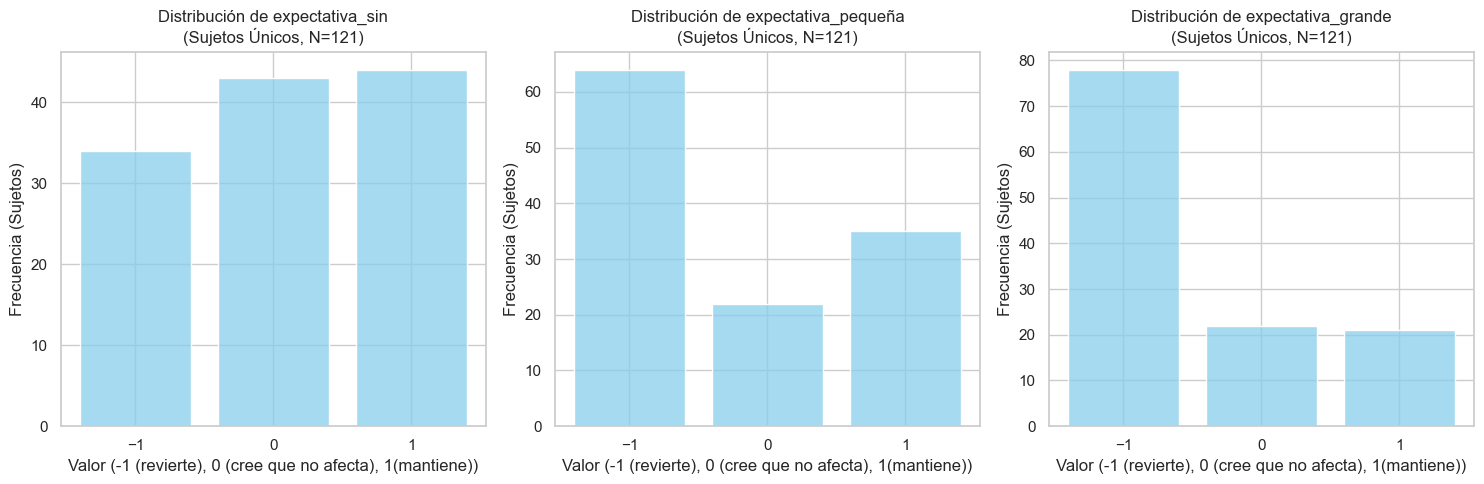

Resumen de Expectativas (N Total = 121)
       expectativa_sin expectativa_pequeña expectativa_grande
Opción                                                       
-1          34 (28.1%)          64 (52.9%)         78 (64.5%)
 0          43 (35.5%)          22 (18.2%)         22 (18.2%)
 1          44 (36.4%)          35 (28.9%)         21 (17.4%)


In [11]:
# 1. Cargar la base
df = pd.read_csv('df_long.csv')

# 2. Filtrar para tener solo un dato por sujeto (evitar inflación de N)
# Esto selecciona la primera aparición de cada sujeto
df_u = df.drop_duplicates(subset=['ID_Sujeto']).copy()

# 3. Distribución de Variables Clave (Histogramas)
vars_clave = ['expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']

plt.figure(figsize=(15, 5)) # Una fila, tres columnas

for i, var in enumerate(vars_clave):
    plt.subplot(1, 3, i+1)
    
    # Usamos discrete=True porque los valores son -1, 0, 1
    sns.histplot(df_u[var], discrete=True, kde=False, color='skyblue', shrink=0.8)
    
    plt.xticks([-1, 0, 1])
    plt.title(f'Distribución de {var}\n(Sujetos Únicos, N={len(df_u)})')
    plt.xlabel('Valor (-1 (revierte), 0 (cree que no afecta), 1(mantiene))')
    plt.ylabel('Frecuencia (Sujetos)')

plt.tight_layout()
plt.show()



# 1. Cargar datos y filtrar sujetos únicos
n_total = len(df_u)

# 2. Definir las variables clave
vars_clave = ['expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']

# 3. Crear un diccionario para consolidar los datos
resumen_datos = {}

for var in vars_clave:
    # Contamos frecuencias
    conteos = df_u[var].value_counts().reindex([-1, 0, 1], fill_value=0)
    # Calculamos porcentajes
    porcentajes = (conteos / n_total * 100).round(1)
    
    # Combinamos ambos en un formato "N (%)" para una lectura rápida
    resumen_datos[var] = [f"{n} ({p}%)" for n, p in zip(conteos, porcentajes)]

# 4. Crear el DataFrame final
tabla_final = pd.DataFrame(resumen_datos, index=[-1, 0, 1])
tabla_final.index.name = 'Opción'

print(f"Resumen de Expectativas (N Total = {n_total})")
print(tabla_final)

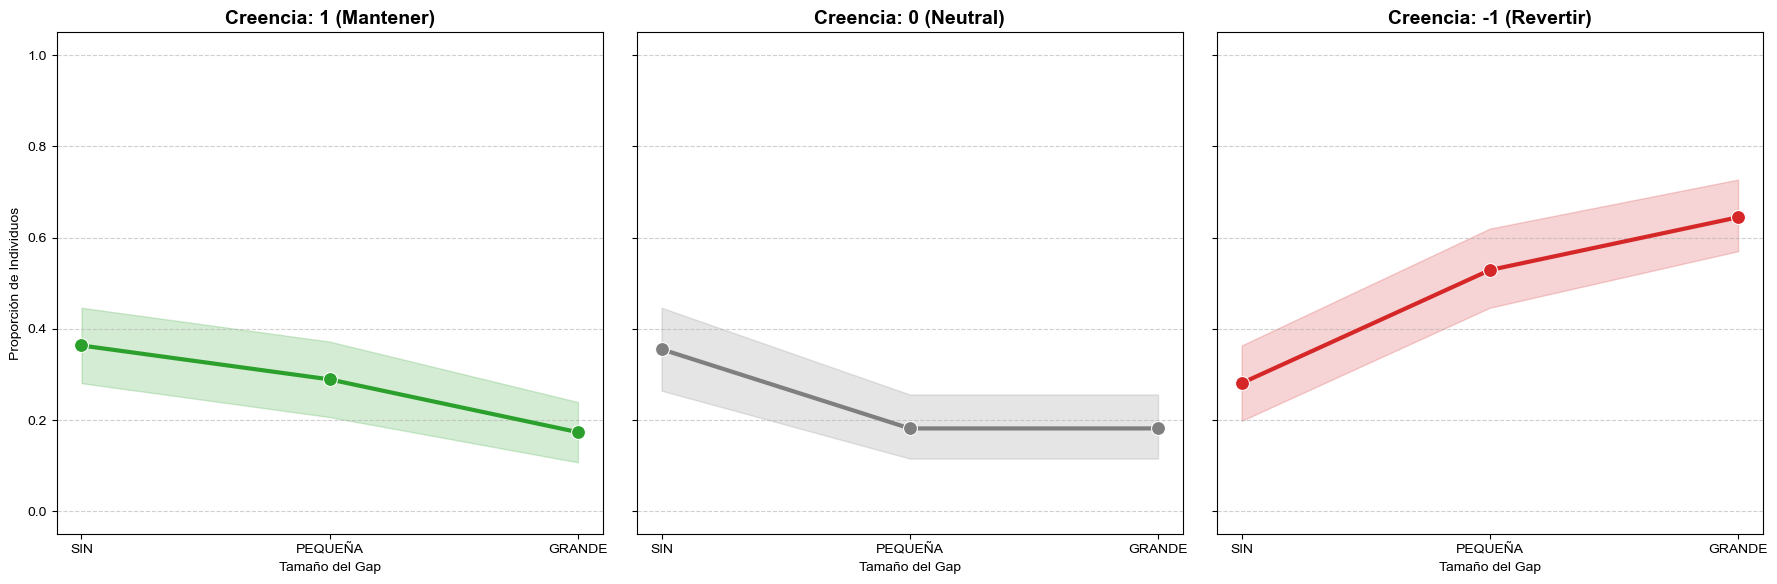

Escenario      Creencia  Cantidad  Proporción
      SIN  1 (Mantener)        44    0.363636
  PEQUEÑA  1 (Mantener)        35    0.289256
   GRANDE  1 (Mantener)        21    0.173554
      SIN   0 (Neutral)        43    0.355372
  PEQUEÑA   0 (Neutral)        22    0.181818
   GRANDE   0 (Neutral)        22    0.181818
      SIN -1 (Revertir)        34    0.280992
  PEQUEÑA -1 (Revertir)        64    0.528926
   GRANDE -1 (Revertir)        78    0.644628


In [4]:
# 2. Transformar a formato largo para el análisis de tendencias
vars_exp = ['expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']
df_melted = df_u.melt(id_vars=['ID_Sujeto'], value_vars=vars_exp, 
                      var_name='Escenario', value_name='Creencia')

# Mapear nombres de escenarios y asegurar orden lógico
escenario_map = {'expectativa_sin': 'SIN', 'expectativa_pequeña': 'PEQUEÑA', 'expectativa_grande': 'GRANDE'}
df_melted['Escenario'] = df_melted['Escenario'].map(escenario_map)
df_melted['Escenario'] = pd.Categorical(df_melted['Escenario'], categories=['SIN', 'PEQUEÑA', 'GRANDE'], ordered=True)

# 3. Crear indicadores binarios (1 si tiene la creencia, 0 si no)
df_melted['Cree_1'] = (df_melted['Creencia'] == 1).astype(int)
df_melted['Cree_0'] = (df_melted['Creencia'] == 0).astype(int)
df_melted['Cree_neg_1'] = (df_melted['Creencia'] == -1).astype(int)

# 4. Graficar los 3 indicadores en una fila
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_theme(style="white")

creencias = ['Cree_1', 'Cree_0', 'Cree_neg_1']
titulos = ['Creencia: 1 (Mantener)', 'Creencia: 0 (Neutral)', 'Creencia: -1 (Revertir)']
colores = ['#2ca02c', '#7f7f7f', '#d62728'] # Verde, Gris, Rojo

for i, cree in enumerate(creencias):
    # Gráfico de línea con bandas (Intervalo de Confianza al 95%)
    sns.lineplot(ax=axes[i], data=df_melted, x='Escenario', y=cree, 
                 marker='o', markersize=10, color=colores[i], linewidth=3, 
                 errorbar=('ci', 95))
    
    axes[i].set_title(titulos[i], fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Proporción de Individuos' if i == 0 else "")
    axes[i].set_xlabel('Tamaño del Gap')
    axes[i].set_ylim(-0.05, 1.05) # Escala de proporción
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 5. Generar tabla de datos de evolución
resumen = []
for cree, label in zip(creencias, ['1 (Mantener)', '0 (Neutral)', '-1 (Revertir)']):
    temp = df_melted.groupby('Escenario', observed=False)[cree].agg(['mean']).reset_index()
    temp['Creencia'] = label
    temp['Cantidad'] = (temp['mean'] * 121).round(0).astype(int)
    resumen.append(temp)

tabla_final = pd.concat(resumen)[['Escenario', 'Creencia', 'Cantidad', 'mean']]
print(tabla_final.rename(columns={'mean': 'Proporción'}).to_string(index=False))

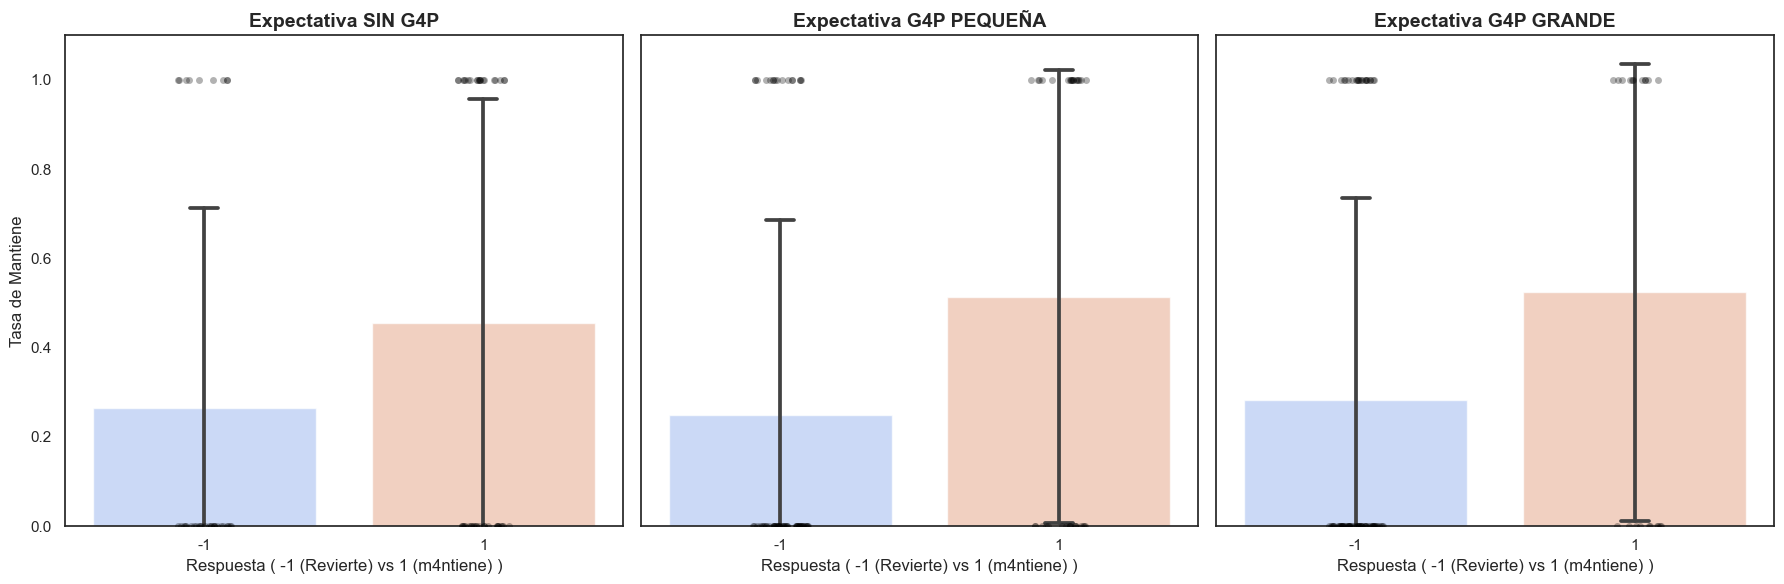

--- TABLAS RESUMEN DE EXPECTATIVAS ---

Expectativa SIN G4P:
 Valor  N  Media    SD
    -1 34  0.265 0.448
     1 44  0.455 0.504

Expectativa G4P PEQUEÑA:
 Valor  N  Media    SD
    -1 64  0.250 0.436
     1 35  0.514 0.507

Expectativa G4P GRANDE:
 Valor  N  Media    SD
    -1 78  0.282 0.453
     1 21  0.524 0.512


In [5]:
# Lista de variables a analizar
vars_exp = ['expectativa_sin_num', 'expectativa_pequeña_num', 'expectativa_grande_num']
titulos = ['Expectativa SIN G4P', 'Expectativa G4P PEQUEÑA', 'Expectativa G4P GRANDE']

# 2. Configurar la figura (3 subplots en una fila)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_theme(style="whitegrid")

tablas_resumen = []

for i, var in enumerate(vars_exp):
    # Filtrar para excluir el 0
    df_temp = df_u[df_u[var] != 0].copy()
    
    # Graficar en el respectivo subplot
    sns.barplot(ax=axes[i], data=df_temp, x=var, y='Mantiene', 
                errorbar='sd', capsize=.1, palette='coolwarm', alpha=0.7)
    
    # Agregar puntos individuales (dispersión)
    sns.stripplot(ax=axes[i], data=df_temp, x=var, y='Mantiene', 
                  color='black', alpha=0.3, jitter=True)
    
    axes[i].set_title(titulos[i], fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Tasa de Mantiene' if i==0 else "")
    axes[i].set_xlabel('Respuesta ( -1 (Revierte) vs 1 (m4ntiene) )')
    axes[i].set_ylim(0, 1.1)
    
    # Guardar datos para la tabla resumen
    resumen = df_temp.groupby(var)['Mantiene'].agg(['count', 'mean', 'std']).reset_index()
    resumen.columns = ['Valor', 'N', 'Media', 'SD']
    resumen['Tipo'] = titulos[i]
    tablas_resumen.append(resumen)

plt.tight_layout()
plt.show()

# 3. Mostrar las tablas resumen
print("--- TABLAS RESUMEN DE EXPECTATIVAS ---")
for t in tablas_resumen:
    print(f"\n{t['Tipo'].iloc[0]}:")
    print(t[['Valor', 'N', 'Media', 'SD']].round(3).to_string(index=False))

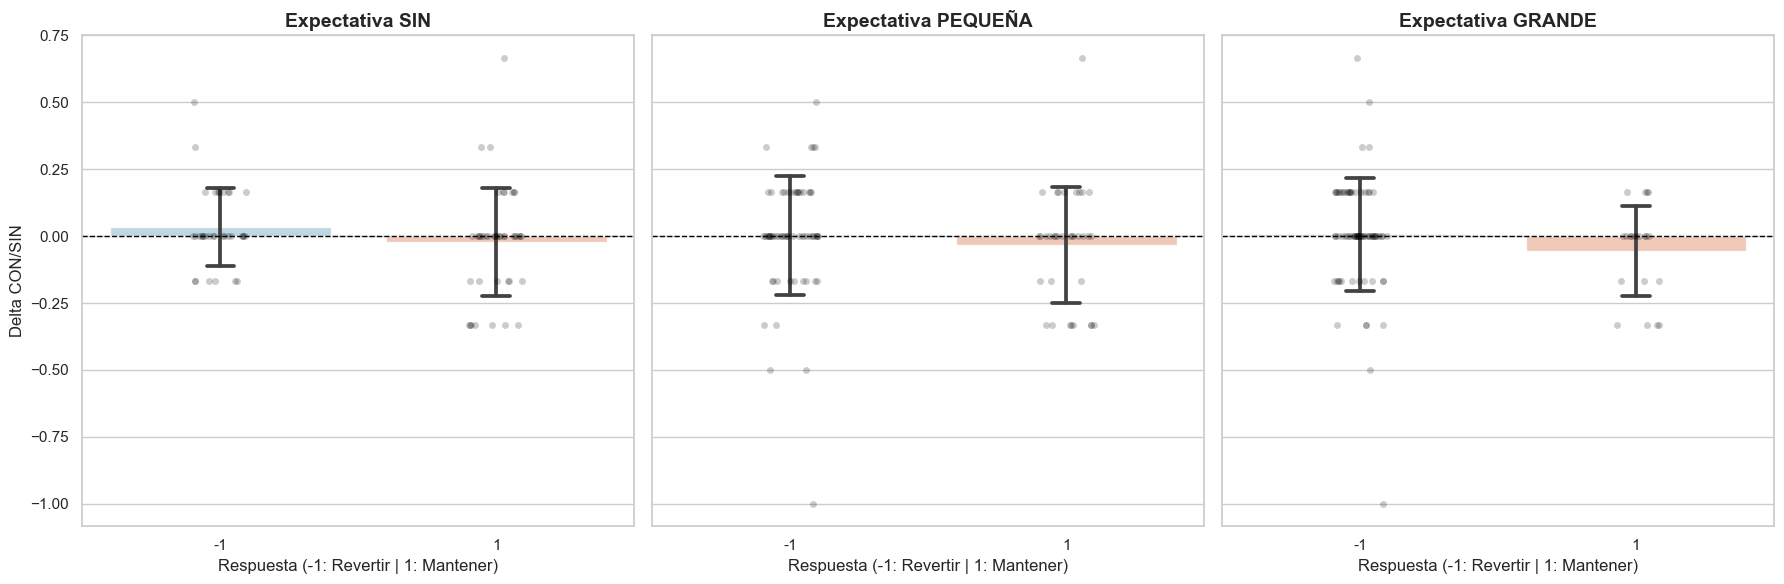

--- TABLAS DE RESULTADOS: DELTA CON/SIN POR EXPECTATIVA ---

Expectativa SIN:
 Respuesta  N  Media Delta  Desv. Estándar
        -1 34        0.034           0.147
         1 44       -0.023           0.202

Expectativa PEQUEÑA:
 Respuesta  N  Media Delta  Desv. Estándar
        -1 64        0.003           0.221
         1 35       -0.033           0.217

Expectativa GRANDE:
 Respuesta  N  Media Delta  Desv. Estándar
        -1 78        0.006           0.212
         1 21       -0.056           0.169


In [6]:
# Definimos las variables de expectativa y sus títulos
vars_exp = ['expectativa_sin_num', 'expectativa_pequeña_num', 'expectativa_grande_num']
titulos = ['Expectativa SIN', 'Expectativa PEQUEÑA', 'Expectativa GRANDE']

# 2. Configurar la figura (3 subplots en una fila)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_theme(style="whitegrid")

for i, var in enumerate(vars_exp):
    # Filtrar para excluir el 0 (neutros/no respuesta)
    df_temp = df_u[df_u[var] != 0].copy()
    
    # Gráfico de barras: Media de Delta_Mantiene con Desviación Estándar
    sns.barplot(ax=axes[i], data=df_temp, x=var, y='Delta_Mantiene', 
                errorbar='sd', capsize=.1, palette='RdBu_r', alpha=0.8)

    # Puntos individuales para ver la dispersión real de cada sujeto
    sns.stripplot(ax=axes[i], data=df_temp, x=var, y='Delta_Mantiene', 
                  color='black', alpha=0.2, jitter=True)

    # Línea de referencia en 0 (indica que no hay cambio respecto a la base)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    
    # Estética de cada subplot
    axes[i].set_title(titulos[i], fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Delta CON/SIN' if i == 0 else "")
    axes[i].set_xlabel('Respuesta (-1: Revertir | 1: Mantener)')

plt.tight_layout()
plt.show()

# 3. Generar y mostrar las tablas de datos para cada gráfico
print("--- TABLAS DE RESULTADOS: DELTA CON/SIN POR EXPECTATIVA ---")
for var, titulo in zip(vars_exp, titulos):
    df_temp = df_u[df_u[var] != 0]
    resumen = df_temp.groupby(var)['Delta_Mantiene'].agg(['count', 'mean', 'std']).reset_index()
    resumen.columns = ['Respuesta', 'N', 'Media Delta', 'Desv. Estándar']
    print(f"\n{titulo}:")
    print(resumen.round(3).to_string(index=False))

--- TABLA 1: PROMEDIO GLOBAL POR GAP VS AZAR ---
 Gap  count  mean   std  Diff_vs_50%
   0    111 0.599 0.348        0.099
1000    111 0.318 0.377       -0.182
1200    111 0.279 0.361       -0.221
2000    111 0.219 0.338       -0.281
2400    111 0.174 0.294       -0.326

--- TABLA 2: PRIMERA APARICIÓN POR GAP VS AZAR ---
 Gap_Size  count  mean   std  Diff_vs_50%
        0     78 0.487 0.503       -0.013
     1000     99 0.354 0.480       -0.146
     1200     99 0.273 0.448       -0.227
     2000     99 0.182 0.388       -0.318
     2400     99 0.172 0.379       -0.328


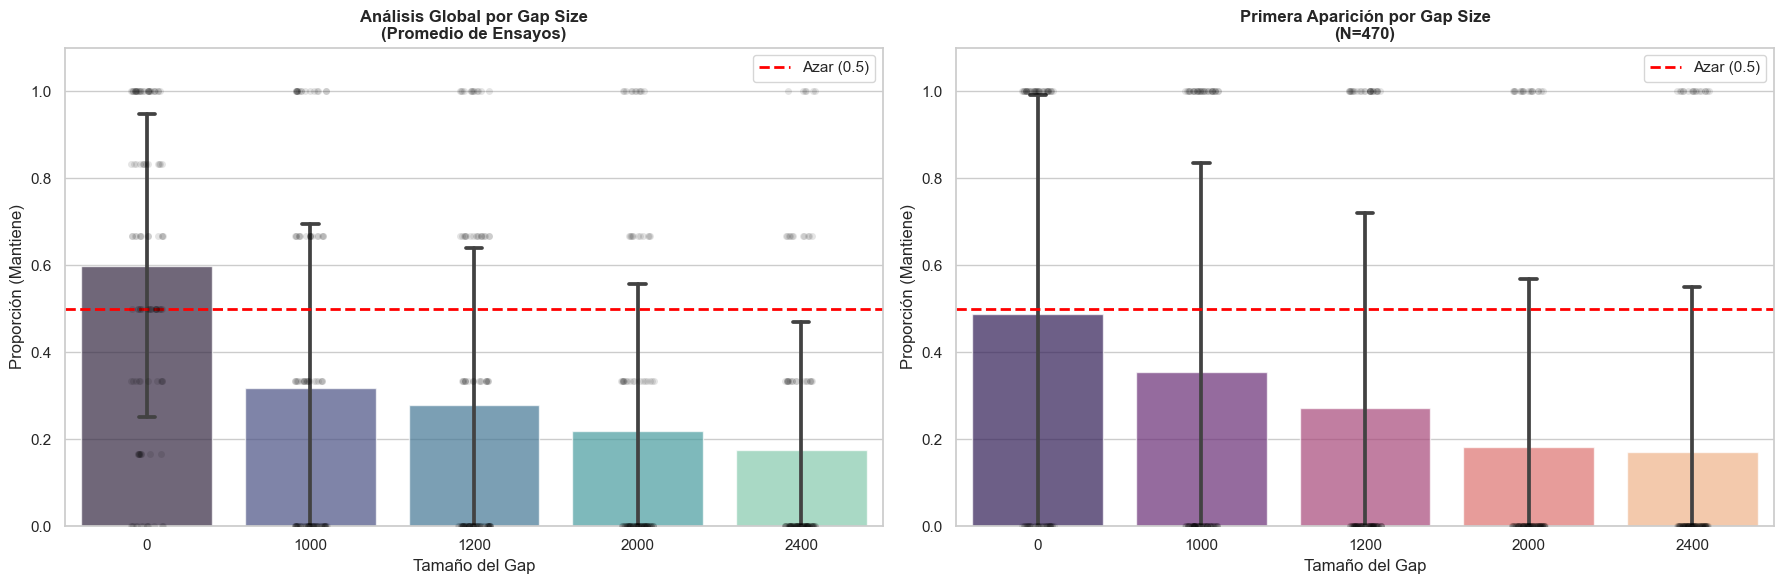

In [7]:
# A. Datos para PROMEDIOS GLOBALES por Gap
cols_gap = [c for c in df_expectativas.columns if c.startswith('Promedio_Gap_')]
df_unicos = df_expectativas.drop_duplicates(subset=['ID_Sujeto'])[['ID_Sujeto'] + cols_gap]
df_plot_global = df_unicos.melt(id_vars='ID_Sujeto', value_vars=cols_gap,
                                var_name='Gap_Col', value_name='Valor')
df_plot_global['Gap'] = df_plot_global['Gap_Col'].str.extract('(\d+)').astype(int)

# B. Datos para PRIMERA APARICIÓN por Gap
df_primera = df_expectativas.drop_duplicates(subset=['ID_Sujeto', 'Gap_Size'], keep='first').copy()

# --- 2. GENERACIÓN DE TABLAS (Comparación vs 0.5) ---

print("--- TABLA 1: PROMEDIO GLOBAL POR GAP VS AZAR ---")
t1 = df_plot_global.groupby('Gap')['Valor'].agg(['count', 'mean', 'std']).reset_index()
t1['Diff_vs_50%'] = (t1['mean'] - 0.5).round(3)
print(t1.round(3).to_string(index=False))

print("\n--- TABLA 2: PRIMERA APARICIÓN POR GAP VS AZAR ---")
t2 = df_primera.groupby('Gap_Size')['Mantiene'].agg(['count', 'mean', 'std']).reset_index()
t2['Diff_vs_50%'] = (t2['mean'] - 0.5).round(3)
print(t2.round(3).to_string(index=False))

# --- 3. VISUALIZACIÓN INTEGRADA ---

sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# GRÁFICO 1: ANÁLISIS GLOBAL (Promedio de todos los ensayos)
sns.barplot(data=df_plot_global, x='Gap', y='Valor', errorbar='sd', 
            capsize=.1, palette='mako', alpha=0.7, ax=ax1)
sns.stripplot(data=df_plot_global, x='Gap', y='Valor', color='black', 
              alpha=0.1, jitter=True, ax=ax1)
ax1.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Azar (0.5)')
ax1.set_title('Análisis Global por Gap Size\n(Promedio de Ensayos)', fontsize=12, fontweight='bold')

# GRÁFICO 2: PRIMERA APARICIÓN (Reacción inicial al costo)
sns.barplot(data=df_primera, x='Gap_Size', y='Mantiene', errorbar='sd', 
            capsize=.1, palette='magma', alpha=0.7, ax=ax2)
sns.stripplot(data=df_primera, x='Gap_Size', y='Mantiene', color='black', 
              alpha=0.1, jitter=True, ax=ax2)
ax2.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Azar (0.5)')
ax2.set_title('Primera Aparición por Gap Size\n(N=470)', fontsize=12, fontweight='bold')

# Ajustes comunes
for ax in [ax1, ax2]:
    ax.set_ylabel('Proporción (Mantiene)')
    ax.set_xlabel('Tamaño del Gap')
    ax.set_ylim(0, 1.1)
    ax.legend()

plt.tight_layout()
plt.show()

--- TABLA 1: PROMEDIOS GENERALES (E.S) ---
           count   mean    std
Condicion                     
CON          111  0.372  0.258
SIN          111  0.380  0.289
DIST         111  0.342  0.257

--- TABLA 2: PRIMERA RESPUESTA (Bloque 1) (E.S) ---
Mantiene    0   1  %_Mantiene
Condicion                    
CON        63  33       34.38
SIN        60  36       37.50
DIST       66  30       31.25

--- TABLA 3: ANÁLISIS DEL DELTA (CON - SIN) (I.S)---
count     111.000
mean       -0.008
std         0.211
median      0.000
min        -1.000
max         0.667
Name: Delta_Mantiene, dtype: float64


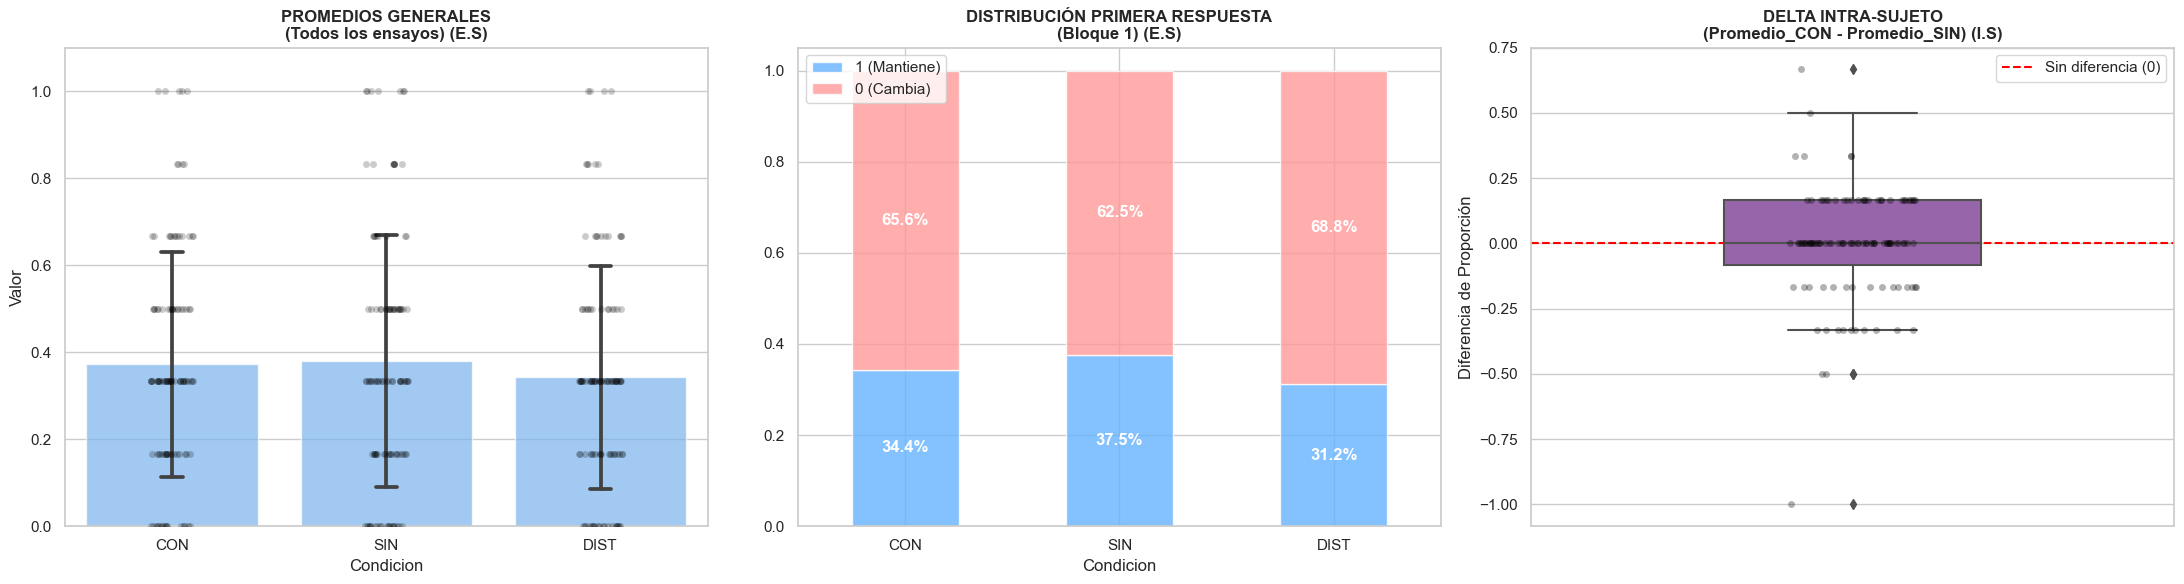

In [10]:
# --- 1. PREPARACIÓN DE DATOS ---

# A. Para el gráfico de PROMEDIOS GENERALES
df_unicos = df_expectativas.drop_duplicates(subset=['ID_Sujeto']).copy()
df_proms = df_unicos.melt(id_vars='ID_Sujeto', 
                          value_vars=['Promedio_CON', 'Promedio_SIN', 'Promedio_DIST'],
                          var_name='Condicion', value_name='Valor')
df_proms['Condicion'] = df_proms['Condicion'].str.replace('Promedio_', '')

# B. Para el gráfico de PRIMERA RESPUESTA (Categoría 1)
df_cat1 = df_expectativas[df_expectativas['Categoria'] == 1].copy()
def mapear(n):
    n = str(n).upper()
    return 'CON' if 'CON' in n else 'SIN' if 'SIN' in n else 'DIST' if 'DIST' in n else n
df_cat1['Condicion'] = df_cat1['Dilema'].apply(mapear)

# C. Cálculo del DELTA (CON - SIN)
df_unicos['Delta_Mantiene'] = df_unicos['Promedio_CON'] - df_unicos['Promedio_SIN']

orden = ['CON', 'SIN', 'DIST']

# --- 2. GENERACIÓN DE TABLAS (Sin cambios en contenido) ---

print("--- TABLA 1: PROMEDIOS GENERALES (E.S) ---")
t1 = df_proms.groupby('Condicion')['Valor'].agg(['count', 'mean', 'std']).loc[orden]
print(t1.round(3))

print("\n--- TABLA 2: PRIMERA RESPUESTA (Bloque 1) (E.S) ---")
t2 = pd.crosstab(df_cat1['Condicion'], df_cat1['Mantiene']).loc[orden]
t2['%_Mantiene'] = (t2[1] / (t2[0] + t2[1]) * 100).round(2)
print(t2)

print("\n--- TABLA 3: ANÁLISIS DEL DELTA (CON - SIN) (I.S)---")
resumen_delta = df_unicos['Delta_Mantiene'].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
print(resumen_delta.round(3))

# --- 3. VISUALIZACIÓN (Panel de 3 gráficos) ---

sns.set_theme(style="whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6)) # Aumentamos el ancho total
colores_apilado = ['#66b3ff', '#ff9999']

# GRÁFICO 1: PROMEDIOS GENERALES
sns.barplot(data=df_proms, x='Condicion', y='Valor', order=orden,
            errorbar='sd', capsize=.1, color='#66b3ff', alpha=0.7, ax=ax1)
sns.stripplot(data=df_proms, x='Condicion', y='Valor', order=orden,
              color='black', alpha=0.2, ax=ax1)
ax1.set_title('PROMEDIOS GENERALES\n(Todos los ensayos) (E.S)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1.1)

# GRÁFICO 2: DISTRIBUCIÓN APILADA (Primera Respuesta)
tab_prop = df_cat1.groupby('Condicion')['Mantiene'].value_counts(normalize=True).unstack()
tab_prop[[1, 0]].loc[orden].plot(kind='bar', stacked=True, color=colores_apilado, alpha=0.8, ax=ax2, rot=0)

for p in ax2.patches:
    h = p.get_height()
    if h > 0:
        ax2.annotate(f'{h:.1%}', (p.get_x() + p.get_width()/2, p.get_y() + h/2),
                     ha='center', va='center', color='white', fontweight='bold')
ax2.set_title('DISTRIBUCIÓN PRIMERA RESPUESTA\n(Bloque 1) (E.S)', fontsize=12, fontweight='bold')
ax2.legend(['1 (Mantiene)', '0 (Cambia)'], loc='upper left')

# GRÁFICO 3: BOXPLOT DEL DELTA (Diferencia Intra-Sujeto)
sns.boxplot(y=df_unicos['Delta_Mantiene'], color='#9b59b6', width=0.4, fliersize=5, ax=ax3)
sns.stripplot(y=df_unicos['Delta_Mantiene'], color='black', alpha=0.3, jitter=True, ax=ax3)
ax3.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Sin diferencia (0)')
ax3.set_title('DELTA INTRA-SUJETO\n(Promedio_CON - Promedio_SIN) (I.S)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Diferencia de Proporción')
ax3.legend()

plt.tight_layout()
plt.savefig('../outputs/plots/panel_completo_resultados.png', dpi=300)
plt.show()